### Import necessary libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scipy as sp
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from scipy import stats
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

### Read in csv files

In [2]:
d_20 = pd.read_csv('offense-2020.csv')
o_20 = pd.read_csv('defense-2020.csv')

d_19 = pd.read_csv('offense-2019.csv')
o_19 = pd.read_csv('defense-2019.csv')

d_18 = pd.read_csv('offense-2018.csv')
o_18 = pd.read_csv('defense-2018.csv')

d_17 = pd.read_csv('offense-2017.csv')
o_17 = pd.read_csv('defense-2017.csv')

d_16 = pd.read_csv('offense-2016.csv')
o_16 = pd.read_csv('defense-2016.csv')

d_15 = pd.read_csv('offense-2015.csv')
o_15 = pd.read_csv('defense-2015.csv')

d_14 = pd.read_csv('offense-2014.csv')
o_14 = pd.read_csv('defense-2014.csv')

d_13 = pd.read_csv('offense-2013.csv')
o_13 = pd.read_csv('defense-2013.csv')

d_12 = pd.read_csv('offense-2012.csv')
o_12 = pd.read_csv('defense-2012.csv')

d_11 = pd.read_csv('offense-2011.csv')
o_11 = pd.read_csv('defense-2011.csv')

d_10 = pd.read_csv('offense-2010.csv')
o_10 = pd.read_csv('defense-2010.csv')

d_09 = pd.read_csv('offense-2009.csv')
o_09 = pd.read_csv('defense-2009.csv')

d_08 = pd.read_csv('offense-2008.csv')
o_08 = pd.read_csv('defense-2008.csv')

d_07 = pd.read_csv('offense-2007.csv')
o_07 = pd.read_csv('defense-2007.csv')

d_06 = pd.read_csv('offense-2006.csv')
o_06 = pd.read_csv('defense-2006.csv')

d_05 = pd.read_csv('offense-2005.csv')
o_05 = pd.read_csv('defense-2005.csv')

d_04 = pd.read_csv('offense-2004.csv')
o_04 = pd.read_csv('defense-2004.csv')

d_03 = pd.read_csv('offense-2003.csv')
o_03 = pd.read_csv('defense-2003.csv')

d_02 = pd.read_csv('offense-2002.csv')
o_02 = pd.read_csv('defense-2002.csv')

d_01 = pd.read_csv('offense-2001.csv')
o_01 = pd.read_csv('defense-2001.csv')

d_00 = pd.read_csv('offense-2000.csv')
o_00 = pd.read_csv('defense-2000.csv')

In [3]:
df_list = [d_19,o_19,d_18,o_18,d_17,o_17,d_16,o_16,d_15,o_15,d_14,o_14,d_13,o_13,d_12,o_12,d_11,o_11,d_10,o_10,d_09,o_09,d_08,o_08,d_07,o_07,d_06,o_06,d_05,o_05,d_04,o_04,d_03,o_03,d_02,o_02,d_01,o_01,d_00,o_00]

In [4]:
df = pd.concat(df_list)

In [5]:
df.shape

(6319, 17)

In [6]:
df.head()

,Rk,Year,Player,Pos,Age,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,1,2019,Caleb Wilson\WilsCa00,TE,22.0,NaN,UCLA,College Stats,6-4,240,4.56,29.0,NaN,113.0,7.20,4.40,Arizona Cardinals / 7th / 254th pick / 2019
1,2,2019,Trayveon Williams\WillTr06,RB,21.0,0.0,Texas A&M,College Stats,5-8,206,4.51,33.0,19.0,121.0,7.44,4.44,Cincinnati Bengals / 6th / 182nd pick / 2019
2,3,2019,Jonah Williams\WillJo10,OT,21.0,NaN,Alabama,College Stats,6-4,302,5.12,28.0,23.0,100.0,8.01,4.79,Cincinnati Bengals / 1st / 11th pick / 2019
3,4,2019,James Williams\WillJa08,RB,22.0,NaN,Washington St.,College Stats,5-9,197,4.58,36.5,NaN,118.0,7.01,4.25,NaN
4,5,2019,Dexter Williams\WillDe07,RB,22.0,0.0,Notre Dame,College Stats,5-11,212,4.57,36.0,17.0,130.0,7.00,4.16,Green Bay Packers / 6th / 194th pick / 2019


### Clean Data

In [7]:
#clean names column
name_list = []
for i in df.Player:
    player_list = i.split("\\")
    name_list.append(player_list[0])
df.Player = name_list

In [8]:
df.head()

,Rk,Year,Player,Pos,Age,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,1,2019,Caleb Wilson,TE,22.0,NaN,UCLA,College Stats,6-4,240,4.56,29.0,NaN,113.0,7.20,4.40,Arizona Cardinals / 7th / 254th pick / 2019
1,2,2019,Trayveon Williams,RB,21.0,0.0,Texas A&M,College Stats,5-8,206,4.51,33.0,19.0,121.0,7.44,4.44,Cincinnati Bengals / 6th / 182nd pick / 2019
2,3,2019,Jonah Williams,OT,21.0,NaN,Alabama,College Stats,6-4,302,5.12,28.0,23.0,100.0,8.01,4.79,Cincinnati Bengals / 1st / 11th pick / 2019
3,4,2019,James Williams,RB,22.0,NaN,Washington St.,College Stats,5-9,197,4.58,36.5,NaN,118.0,7.01,4.25,NaN
4,5,2019,Dexter Williams,RB,22.0,0.0,Notre Dame,College Stats,5-11,212,4.57,36.0,17.0,130.0,7.00,4.16,Green Bay Packers / 6th / 194th pick / 2019


In [9]:
#handle undrafted players by replacing nan with 8
round_dict = {np.nan:'No Team / 8th / 700th pick / 2100'}
df['Drafted (tm/rnd/yr)'].replace(round_dict, inplace = True)

In [10]:
age_dict = {np.nan:22}
df['Age'].replace(age_dict, inplace = True)

In [11]:
#clean draft position of players in new_df
clean_round_drafted = []
for i in df['Drafted (tm/rnd/yr)']:
    draft_list = i.split("/")
    round_drafted = draft_list[1][1]
    clean_round_drafted.append(round_drafted)
df['Round'] = clean_round_drafted
df.drop(columns = ['Drafted (tm/rnd/yr)'], inplace = True)

In [12]:
df.head()

,Rk,Year,Player,Pos,Age,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round
0,1,2019,Caleb Wilson,TE,22.0,NaN,UCLA,College Stats,6-4,240,4.56,29.0,NaN,113.0,7.20,4.40,7
1,2,2019,Trayveon Williams,RB,21.0,0.0,Texas A&M,College Stats,5-8,206,4.51,33.0,19.0,121.0,7.44,4.44,6
2,3,2019,Jonah Williams,OT,21.0,NaN,Alabama,College Stats,6-4,302,5.12,28.0,23.0,100.0,8.01,4.79,1
3,4,2019,James Williams,RB,22.0,NaN,Washington St.,College Stats,5-9,197,4.58,36.5,NaN,118.0,7.01,4.25,8
4,5,2019,Dexter Williams,RB,22.0,0.0,Notre Dame,College Stats,5-11,212,4.57,36.0,17.0,130.0,7.00,4.16,6


In [13]:
df.drop(columns = ['Rk', 'AV', 'College'], inplace = True)

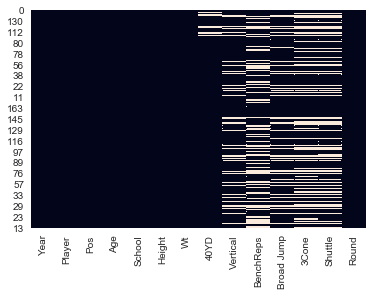

In [14]:
sns.heatmap(df.isnull(), cbar=False)

In [15]:
df.shape

(6319, 14)

In [16]:
df.Pos.value_counts()

WR      905
CB      666
RB      567
OT      494
DE      488
DT      463
OLB     424
OG      379
QB      367
TE      358
ILB     276
FS      229
SS      213
C       171
FB      118
S        56
EDGE     47
LB       40
DL       33
OL       25
Name: Pos, dtype: int64

In [24]:
pos_dict = {'S':'FS', 'OL':'OG', 'DL':'DT', 'LB':'OLB', 'EDGE':'DE'}
df.Pos.replace(pos_dict, inplace = True)

### Explore Relationships

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


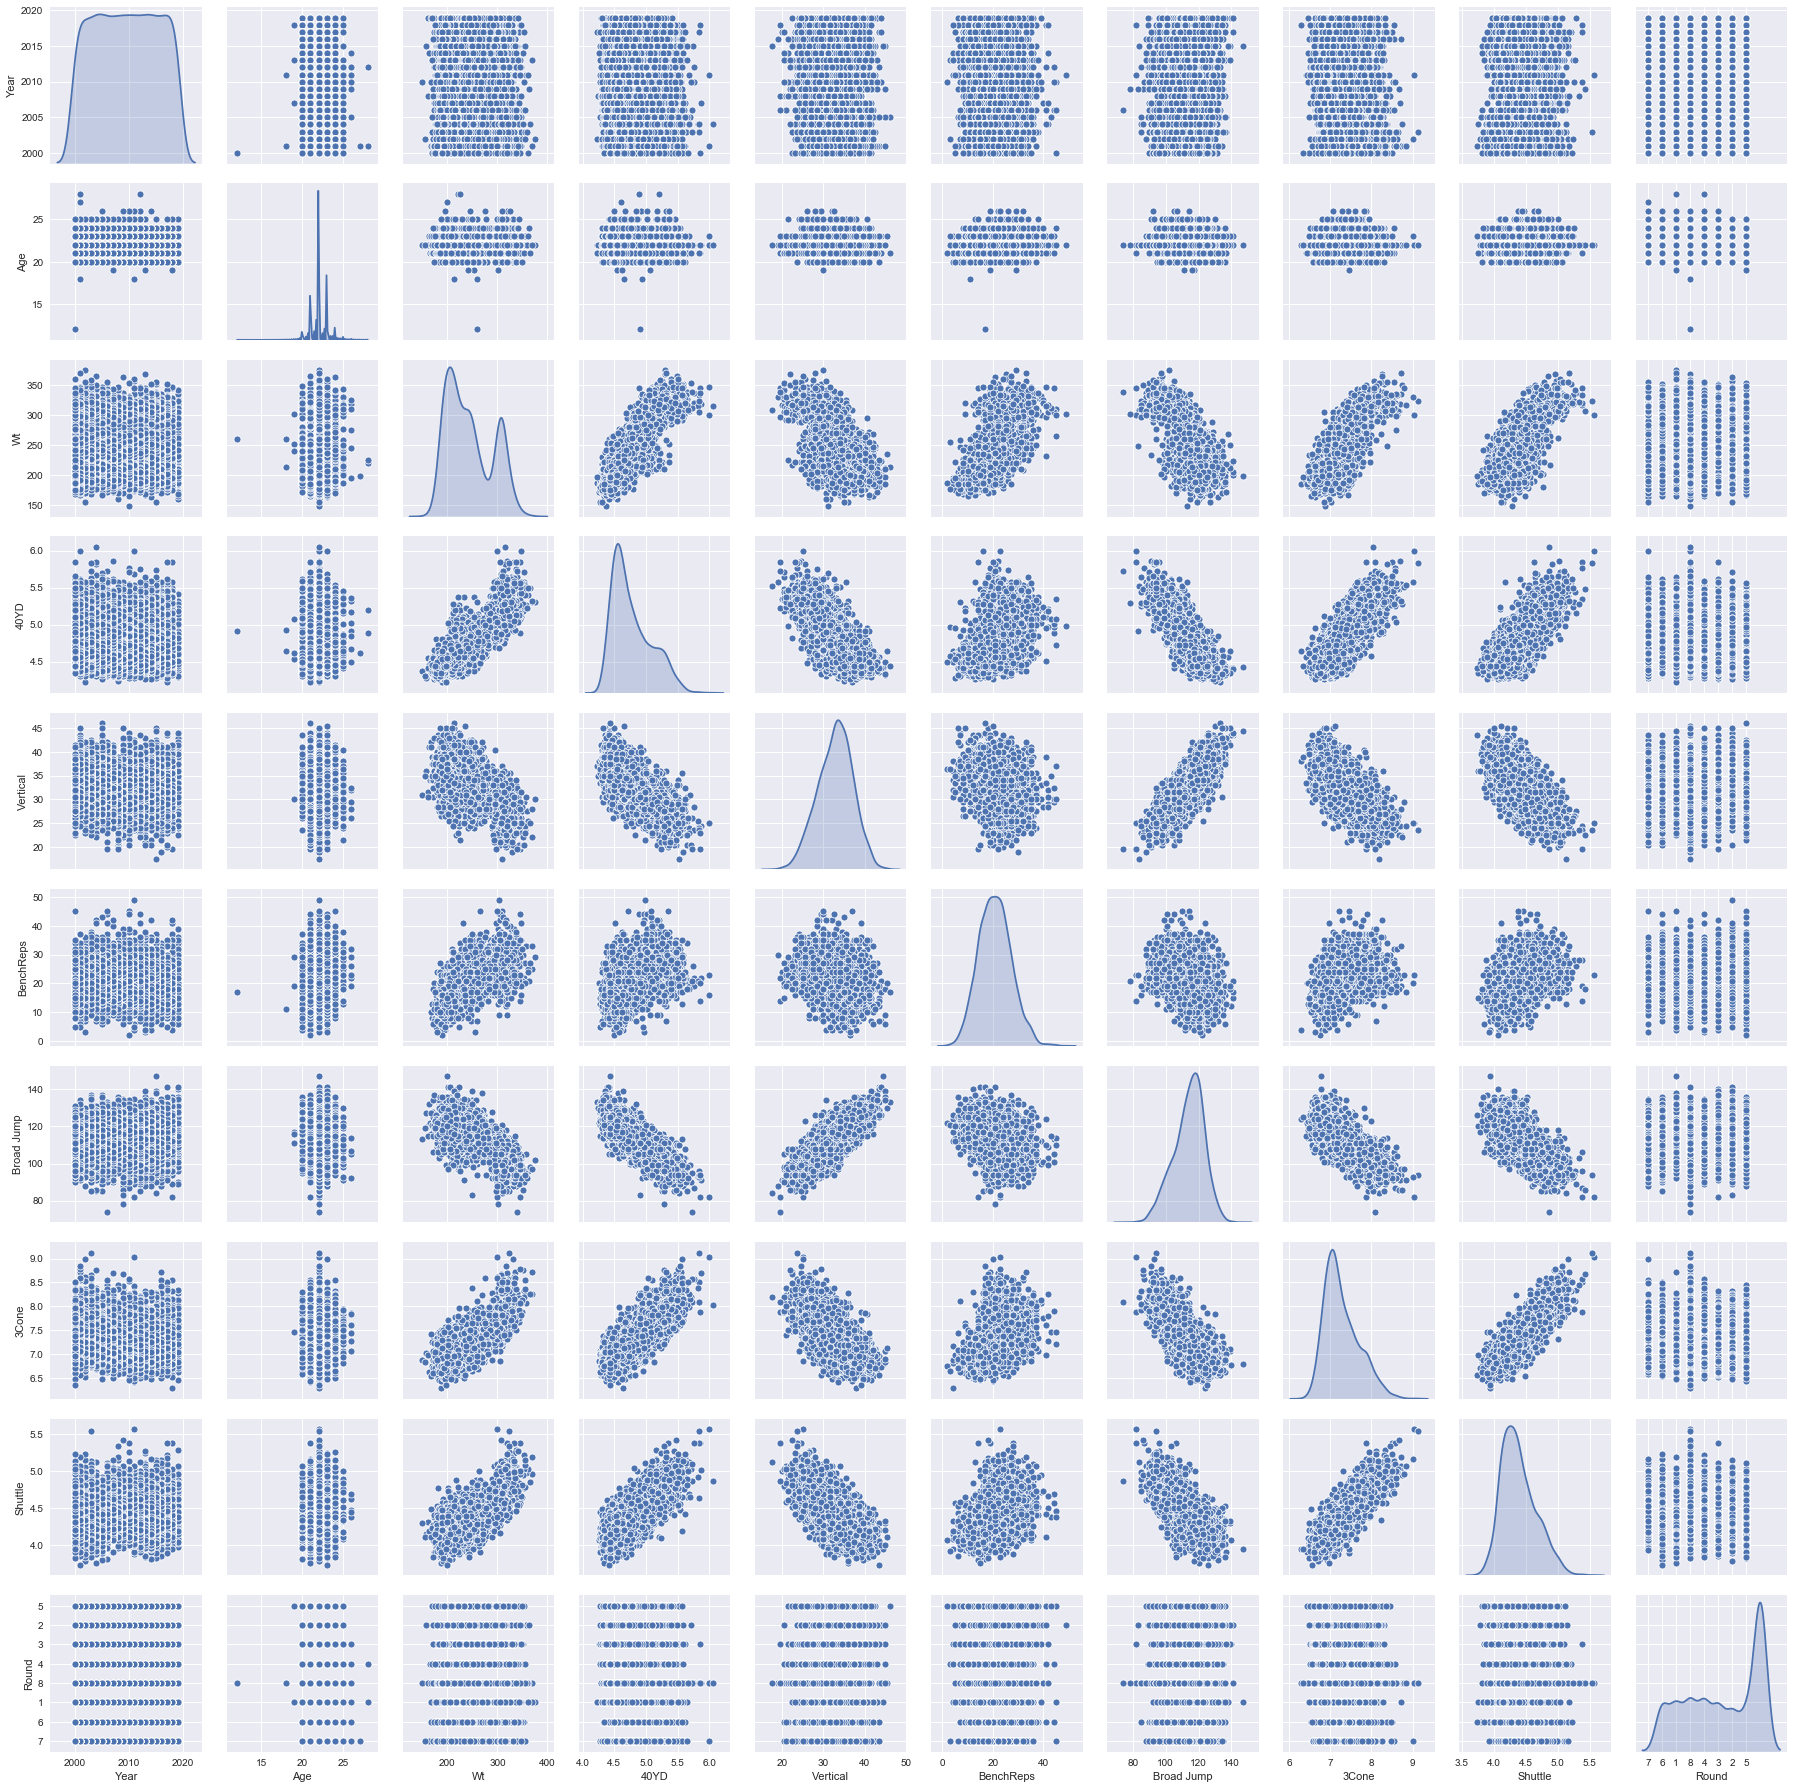

In [25]:
sns.pairplot(df, diag_kind="kde", height=2.5)

In [26]:
df.head()

,Year,Player,Pos,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round
0,2019,Caleb Wilson,TE,22.0,UCLA,6-4,240,4.56,29.0,NaN,113.0,7.20,4.40,7
1,2019,Trayveon Williams,RB,21.0,Texas A&M,5-8,206,4.51,33.0,19.0,121.0,7.44,4.44,6
2,2019,Jonah Williams,OT,21.0,Alabama,6-4,302,5.12,28.0,23.0,100.0,8.01,4.79,1
3,2019,James Williams,RB,22.0,Washington St.,5-9,197,4.58,36.5,NaN,118.0,7.01,4.25,8
4,2019,Dexter Williams,RB,22.0,Notre Dame,5-11,212,4.57,36.0,17.0,130.0,7.00,4.16,6


### Deal with missing data

In [27]:
mean_by_pos_40 = df.groupby('Pos')['40YD'].mean()
std_by_pos_40 = df.groupby('Pos')['40YD'].std()
nan_penalty_40 = mean_by_pos_40 + .5*std_by_pos_40

mean_by_pos_vert = df.groupby('Pos')['Vertical'].mean()
std_by_pos_vert = df.groupby('Pos')['Vertical'].std()
nan_penalty_vert = mean_by_pos_vert - .5*std_by_pos_vert

mean_by_pos_bench = df.groupby('Pos')['BenchReps'].mean()
std_by_pos_bench = df.groupby('Pos')['BenchReps'].std()
nan_penalty_bench = mean_by_pos_bench - .5*std_by_pos_bench

mean_by_pos_broad = df.groupby('Pos')['Broad Jump'].mean()
std_by_pos_broad = df.groupby('Pos')['Broad Jump'].std()
nan_penalty_broad = mean_by_pos_broad - .5*std_by_pos_broad


mean_by_pos_3cone = df.groupby('Pos')['3Cone'].mean()
std_by_pos_3cone = df.groupby('Pos')['3Cone'].std()
nan_penalty_3cone = mean_by_pos_3cone + .5*std_by_pos_3cone

mean_by_pos_shuttle = df.groupby('Pos')['Shuttle'].mean()
std_by_pos_shuttle = df.groupby('Pos')['Shuttle'].std()
nan_penalty_shuttle = mean_by_pos_shuttle + .5*std_by_pos_shuttle

In [28]:
print("nan_penalty_40")
print(nan_penalty_40)
print("")
print("nan_penalty_vert")
print(nan_penalty_vert)
print("")
print("nan_penalty_bench")
print(nan_penalty_bench)
print("")
print("nan_penalty_broad")
print(nan_penalty_broad)
print("")
print("nan_penalty_3cone")
print(nan_penalty_3cone)
print("")
print("nan_penalty_shuttle")
print(nan_penalty_shuttle)

nan_penalty_40
Pos
C      5.319924
CB     4.541584
DE     4.893102
DT     5.170493
FB     4.832669
FS     4.609266
ILB    4.814414
OG     5.394333
OLB    4.734316
OT     5.339185
QB     4.914067
RB     4.611794
SS     4.619766
TE     4.841208
WR     4.562142
Name: 40YD, dtype: float64

nan_penalty_vert
Pos
C      26.509700
CB     34.577116
DE     31.450307
DT     27.864409
FB     31.210632
FS     34.166669
ILB    31.735044
OG     26.062851
OLB    32.804533
OT     26.537368
QB     29.496755
RB     32.895829
SS     33.883471
TE     31.340777
WR     33.725323
Name: Vertical, dtype: float64

nan_penalty_bench
Pos
C      23.646150
CB     12.432329
DE     21.387198
DT     24.903738
FB     20.370783
FS     14.360253
ILB    20.165818
OG     22.926322
OLB    20.045840
OT     21.961435
QB     17.145077
RB     17.113607
SS     15.365649
TE     18.028782
WR     12.486491
Name: BenchReps, dtype: float64

nan_penalty_broad
Pos
C       98.421912
CB     119.022484
DE     111.816697
DT     102.186387
F

In [29]:
df.Pos.unique()

array(['TE', 'RB', 'OT', 'WR', 'QB', 'OG', 'FB', 'CB', 'DE', 'DT', 'FS',
       'OLB', 'C', 'ILB', 'SS'], dtype=object)

In [30]:
df.set_index('Pos', inplace = True)

In [31]:
# make positional dataframes
C = df.loc['C', :]
CB = df.loc['CB', :]
DE = df.loc['DE', :]
DT = df.loc['DT', :]
FB = df.loc['FB', :]
FS = df.loc['FS', :]
ILB = df.loc['ILB', :]
OG = df.loc['OG', :]
OLB = df.loc['OLB', :]
OT = df.loc['OT', :]
QB = df.loc['QB', :]
RB = df.loc['RB', :]
SS = df.loc['SS', :]
TE = df.loc['TE', :]
WR = df.loc['WR', :]

In [32]:
C['40YD'].fillna(nan_penalty_40['C'], inplace = True)
CB['40YD'].fillna(nan_penalty_40['CB'], inplace = True)
DE['40YD'].fillna(nan_penalty_40['DE'], inplace = True)
DT['40YD'].fillna(nan_penalty_40['DT'], inplace = True)
FB['40YD'].fillna(nan_penalty_40['FB'], inplace = True)
FS['40YD'].fillna(nan_penalty_40['FS'], inplace = True)
ILB['40YD'].fillna(nan_penalty_40['ILB'], inplace = True)
OG['40YD'].fillna(nan_penalty_40['OG'], inplace = True)
OLB['40YD'].fillna(nan_penalty_40['OLB'], inplace = True)
OT['40YD'].fillna(nan_penalty_40['OT'], inplace = True)
QB['40YD'].fillna(nan_penalty_40['QB'], inplace = True)
RB['40YD'].fillna(nan_penalty_40['RB'], inplace = True)
SS['40YD'].fillna(nan_penalty_40['SS'], inplace = True)
TE['40YD'].fillna(nan_penalty_40['TE'], inplace = True)
WR['40YD'].fillna(nan_penalty_40['WR'], inplace = True)

/Users/sullivanmyer/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [33]:
print(C['40YD'].isna().sum())
print(CB['40YD'].isna().sum())
print(DE['40YD'].isna().sum())
print(DT['40YD'].isna().sum())
print(FB['40YD'].isna().sum())
print(FS['40YD'].isna().sum())
print(ILB['40YD'].isna().sum())
print(OG['40YD'].isna().sum())
print(OLB['40YD'].isna().sum())
print(OT['40YD'].isna().sum())
print(QB['40YD'].isna().sum())
print(RB['40YD'].isna().sum())
print(SS['40YD'].isna().sum())
print(TE['40YD'].isna().sum())
print(WR['40YD'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [34]:
C['Vertical'].fillna(nan_penalty_vert['C'], inplace = True)
CB['Vertical'].fillna(nan_penalty_vert['CB'], inplace = True)
DE['Vertical'].fillna(nan_penalty_vert['DE'], inplace = True)
DT['Vertical'].fillna(nan_penalty_vert['DT'], inplace = True)
FB['Vertical'].fillna(nan_penalty_vert['FB'], inplace = True)
FS['Vertical'].fillna(nan_penalty_vert['FS'], inplace = True)
ILB['Vertical'].fillna(nan_penalty_vert['ILB'], inplace = True)
OG['Vertical'].fillna(nan_penalty_vert['OG'], inplace = True)
OLB['Vertical'].fillna(nan_penalty_vert['OLB'], inplace = True)
OT['Vertical'].fillna(nan_penalty_vert['OT'], inplace = True)
QB['Vertical'].fillna(nan_penalty_vert['QB'], inplace = True)
RB['Vertical'].fillna(nan_penalty_vert['RB'], inplace = True)
SS['Vertical'].fillna(nan_penalty_vert['SS'], inplace = True)
TE['Vertical'].fillna(nan_penalty_vert['TE'], inplace = True)
WR['Vertical'].fillna(nan_penalty_vert['WR'], inplace = True)

In [35]:
print(C['Vertical'].isna().sum())
print(CB['Vertical'].isna().sum())
print(DE['Vertical'].isna().sum())
print(DT['Vertical'].isna().sum())
print(FB['Vertical'].isna().sum())
print(FS['Vertical'].isna().sum())
print(ILB['Vertical'].isna().sum())
print(OG['Vertical'].isna().sum())
print(OLB['Vertical'].isna().sum())
print(OT['Vertical'].isna().sum())
print(QB['Vertical'].isna().sum())
print(RB['Vertical'].isna().sum())
print(SS['Vertical'].isna().sum())
print(TE['Vertical'].isna().sum())
print(WR['Vertical'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [36]:
C['BenchReps'].fillna(nan_penalty_bench['C'], inplace = True)
CB['BenchReps'].fillna(nan_penalty_bench['CB'], inplace = True)
DE['BenchReps'].fillna(nan_penalty_bench['DE'], inplace = True)
DT['BenchReps'].fillna(nan_penalty_bench['DT'], inplace = True)
FB['BenchReps'].fillna(nan_penalty_bench['FB'], inplace = True)
FS['BenchReps'].fillna(nan_penalty_bench['FS'], inplace = True)
ILB['BenchReps'].fillna(nan_penalty_bench['ILB'], inplace = True)
OG['BenchReps'].fillna(nan_penalty_bench['OG'], inplace = True)
OLB['BenchReps'].fillna(nan_penalty_bench['OLB'], inplace = True)
OT['BenchReps'].fillna(nan_penalty_bench['OT'], inplace = True)
QB['BenchReps'].fillna(nan_penalty_bench['QB'], inplace = True)
RB['BenchReps'].fillna(nan_penalty_bench['RB'], inplace = True)
SS['BenchReps'].fillna(nan_penalty_bench['SS'], inplace = True)
TE['BenchReps'].fillna(nan_penalty_bench['TE'], inplace = True)
WR['BenchReps'].fillna(nan_penalty_bench['WR'], inplace = True)

In [37]:
print(C['BenchReps'].isna().sum())
print(CB['BenchReps'].isna().sum())
print(DE['BenchReps'].isna().sum())
print(DT['BenchReps'].isna().sum())
print(FB['BenchReps'].isna().sum())
print(FS['BenchReps'].isna().sum())
print(ILB['BenchReps'].isna().sum())
print(OG['BenchReps'].isna().sum())
print(OLB['BenchReps'].isna().sum())
print(OT['BenchReps'].isna().sum())
print(QB['BenchReps'].isna().sum())
print(RB['BenchReps'].isna().sum())
print(SS['BenchReps'].isna().sum())
print(TE['BenchReps'].isna().sum())
print(WR['BenchReps'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [38]:
C['Broad Jump'].fillna(nan_penalty_broad['C'], inplace = True)
CB['Broad Jump'].fillna(nan_penalty_broad['CB'], inplace = True)
DE['Broad Jump'].fillna(nan_penalty_broad['DE'], inplace = True)
DT['Broad Jump'].fillna(nan_penalty_broad['DT'], inplace = True)
FB['Broad Jump'].fillna(nan_penalty_broad['FB'], inplace = True)
FS['Broad Jump'].fillna(nan_penalty_broad['FS'], inplace = True)
ILB['Broad Jump'].fillna(nan_penalty_broad['ILB'], inplace = True)
OG['Broad Jump'].fillna(nan_penalty_broad['OG'], inplace = True)
OLB['Broad Jump'].fillna(nan_penalty_broad['OLB'], inplace = True)
OT['Broad Jump'].fillna(nan_penalty_broad['OT'], inplace = True)
QB['Broad Jump'].fillna(nan_penalty_broad['QB'], inplace = True)
RB['Broad Jump'].fillna(nan_penalty_broad['RB'], inplace = True)
SS['Broad Jump'].fillna(nan_penalty_broad['SS'], inplace = True)
TE['Broad Jump'].fillna(nan_penalty_broad['TE'], inplace = True)
WR['Broad Jump'].fillna(nan_penalty_broad['WR'], inplace = True)

In [39]:
print(C['Broad Jump'].isna().sum())
print(CB['Broad Jump'].isna().sum())
print(DE['Broad Jump'].isna().sum())
print(DT['Broad Jump'].isna().sum())
print(FB['Broad Jump'].isna().sum())
print(FS['Broad Jump'].isna().sum())
print(ILB['Broad Jump'].isna().sum())
print(OG['Broad Jump'].isna().sum())
print(OLB['Broad Jump'].isna().sum())
print(OT['Broad Jump'].isna().sum())
print(QB['Broad Jump'].isna().sum())
print(RB['Broad Jump'].isna().sum())
print(SS['Broad Jump'].isna().sum())
print(TE['Broad Jump'].isna().sum())
print(WR['Broad Jump'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [40]:
C['3Cone'].fillna(nan_penalty_3cone['C'], inplace = True)
CB['3Cone'].fillna(nan_penalty_3cone['CB'], inplace = True)
DE['3Cone'].fillna(nan_penalty_3cone['DE'], inplace = True)
DT['3Cone'].fillna(nan_penalty_3cone['DT'], inplace = True)
FB['3Cone'].fillna(nan_penalty_3cone['FB'], inplace = True)
FS['3Cone'].fillna(nan_penalty_3cone['FS'], inplace = True)
ILB['3Cone'].fillna(nan_penalty_3cone['ILB'], inplace = True)
OG['3Cone'].fillna(nan_penalty_3cone['OG'], inplace = True)
OLB['3Cone'].fillna(nan_penalty_3cone['OLB'], inplace = True)
OT['3Cone'].fillna(nan_penalty_3cone['OT'], inplace = True)
QB['3Cone'].fillna(nan_penalty_3cone['QB'], inplace = True)
RB['3Cone'].fillna(nan_penalty_3cone['RB'], inplace = True)
SS['3Cone'].fillna(nan_penalty_3cone['SS'], inplace = True)
TE['3Cone'].fillna(nan_penalty_3cone['TE'], inplace = True)
WR['3Cone'].fillna(nan_penalty_3cone['WR'], inplace = True)

In [41]:
print(C['3Cone'].isna().sum())
print(CB['3Cone'].isna().sum())
print(DE['3Cone'].isna().sum())
print(DT['3Cone'].isna().sum())
print(FB['3Cone'].isna().sum())
print(FS['3Cone'].isna().sum())
print(ILB['3Cone'].isna().sum())
print(OG['3Cone'].isna().sum())
print(OLB['3Cone'].isna().sum())
print(OT['3Cone'].isna().sum())
print(QB['3Cone'].isna().sum())
print(RB['3Cone'].isna().sum())
print(SS['3Cone'].isna().sum())
print(TE['3Cone'].isna().sum())
print(WR['3Cone'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [42]:
C['Shuttle'].fillna(nan_penalty_shuttle['C'], inplace = True)
CB['Shuttle'].fillna(nan_penalty_shuttle['CB'], inplace = True)
DE['Shuttle'].fillna(nan_penalty_shuttle['DE'], inplace = True)
DT['Shuttle'].fillna(nan_penalty_shuttle['DT'], inplace = True)
FB['Shuttle'].fillna(nan_penalty_shuttle['FB'], inplace = True)
FS['Shuttle'].fillna(nan_penalty_shuttle['FS'], inplace = True)
ILB['Shuttle'].fillna(nan_penalty_shuttle['ILB'], inplace = True)
OG['Shuttle'].fillna(nan_penalty_shuttle['OG'], inplace = True)
OLB['Shuttle'].fillna(nan_penalty_shuttle['OLB'], inplace = True)
OT['Shuttle'].fillna(nan_penalty_shuttle['OT'], inplace = True)
QB['Shuttle'].fillna(nan_penalty_shuttle['QB'], inplace = True)
RB['Shuttle'].fillna(nan_penalty_shuttle['RB'], inplace = True)
SS['Shuttle'].fillna(nan_penalty_shuttle['SS'], inplace = True)
TE['Shuttle'].fillna(nan_penalty_shuttle['TE'], inplace = True)
WR['Shuttle'].fillna(nan_penalty_shuttle['WR'], inplace = True)

In [43]:
print(C['Shuttle'].isna().sum())
print(CB['Shuttle'].isna().sum())
print(DE['Shuttle'].isna().sum())
print(DT['Shuttle'].isna().sum())
print(FB['Shuttle'].isna().sum())
print(FS['Shuttle'].isna().sum())
print(ILB['Shuttle'].isna().sum())
print(OG['Shuttle'].isna().sum())
print(OLB['Shuttle'].isna().sum())
print(OT['Shuttle'].isna().sum())
print(QB['Shuttle'].isna().sum())
print(RB['Shuttle'].isna().sum())
print(SS['Shuttle'].isna().sum())
print(TE['Shuttle'].isna().sum())
print(WR['Shuttle'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [44]:
pos_dfs = [C,CB,DE,DT,FB,FS,ILB,OG,OLB,OT,QB,RB,SS,TE,WR]
new_df = pd.concat(pos_dfs) 

In [45]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round
Pos,,,,,,,,,,,,,
C,2018,Sean Welsh,23.0,Iowa,6-3,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8
C,2018,Coleman Shelton,22.0,Washington,6-3,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8
C,2018,Frank Ragnow,21.0,Arkansas,6-5,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1
C,2018,Scott Quessenberry,22.0,UCLA,6-4,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5
C,2018,Billy Price,23.0,Ohio St.,6-4,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1


In [46]:
new_df.shape

(6319, 13)

In [47]:
new_df.isna().sum()

Year          0
Player        0
Age           0
School        0
Height        0
Wt            0
40YD          0
Vertical      0
BenchReps     0
Broad Jump    0
3Cone         0
Shuttle       0
Round         0
dtype: int64

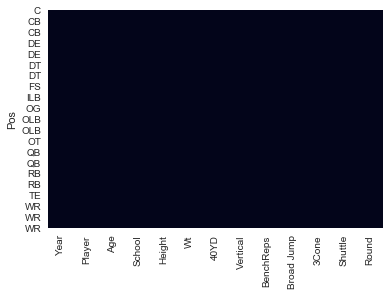

In [48]:
sns.heatmap(new_df.isnull(), cbar = False)

In [49]:
new_df.dtypes

Year            int64
Player         object
Age           float64
School         object
Height         object
Wt              int64
40YD          float64
Vertical      float64
BenchReps     float64
Broad Jump    float64
3Cone         float64
Shuttle       float64
Round          object
dtype: object

In [50]:
split_lst = []
for i in range(len(new_df)):
    split_lst.append(new_df.iloc[i,4].split("-"))

ht_lst = []
for i in split_lst:
    ht_lst.append(12*int(i[0]) + int(i[1]))
new_df['Height'] = ht_lst

In [51]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round
Pos,,,,,,,,,,,,,
C,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8
C,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8
C,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1
C,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5
C,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1


In [52]:
new_df.dtypes

Year            int64
Player         object
Age           float64
School         object
Height          int64
Wt              int64
40YD          float64
Vertical      float64
BenchReps     float64
Broad Jump    float64
3Cone         float64
Shuttle       float64
Round          object
dtype: object

In [53]:
new_df['Position'] = [new_df.index[i] for i in range(len(new_df))]

In [54]:
new_df.index[0]

'C'

In [55]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position
Pos,,,,,,,,,,,,,,
C,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C
C,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C
C,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C
C,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C
C,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C


In [56]:
new_df.reset_index(drop = True, inplace = True)

In [57]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position
0,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C
1,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C
2,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C
3,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C
4,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C


In [70]:
new_df['Round'] = [int(i) for i in new_df['Round']]

In [73]:
new_df['Drafted'] = [1 if i < 8 else 0 for i in new_df['Round']]

In [74]:
new_df.dtypes

Year            int64
Player         object
Age           float64
School         object
Height          int64
Wt              int64
40YD          float64
Vertical      float64
BenchReps     float64
Broad Jump    float64
3Cone         float64
Shuttle       float64
Round           int64
Position       object
Drafted         int64
dtype: object

In [75]:
new_df.head()

,Year,Player,Age,School,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Position,Drafted
0,2018,Sean Welsh,23.0,Iowa,75,306,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,8,C,0
1,2018,Coleman Shelton,22.0,Washington,75,292,5.240000,26.5000,23.64615,110.000000,7.62000,4.59000,8,C,0
2,2018,Frank Ragnow,21.0,Arkansas,77,312,5.319924,26.5097,26.00000,98.421912,7.86268,4.72272,1,C,1
3,2018,Scott Quessenberry,22.0,UCLA,76,310,5.090000,33.5000,25.00000,111.000000,7.50000,4.69000,5,C,1
4,2018,Billy Price,23.0,Ohio St.,76,305,5.319924,26.5097,23.64615,98.421912,7.86268,4.72272,1,C,1


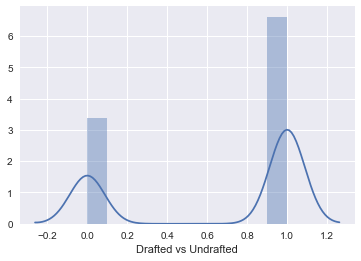

In [100]:
sns.distplot(new_df.Drafted, axlabel = 'Drafted vs Undrafted')

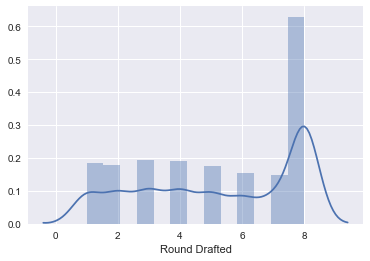

In [101]:
sns.distplot(new_df.Round, axlabel = 'Round Drafted')

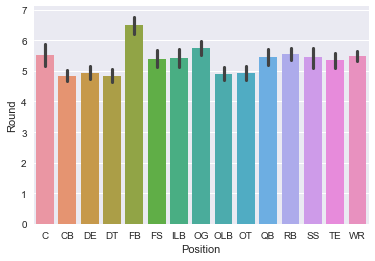

In [116]:
sns.barplot(y=new_df['Round'], x=new_df.Position)

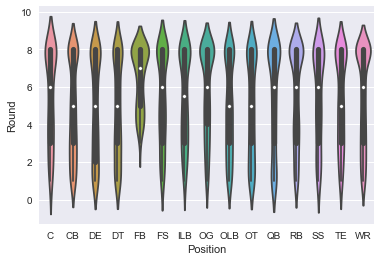

In [110]:
sns.violinplot(y=new_df['Round'], x=new_df.Position, showfliers=False)

In [131]:
new_df.groupby('Position')['Round'].mean()

Position
C      5.508772
CB     4.842342
DE     4.927103
DT     4.824597
FB     6.491525
FS     5.400000
ILB    5.405797
OG     5.752475
OLB    4.911638
OT     4.921053
QB     5.455041
RB     5.548501
SS     5.450704
TE     5.340782
WR     5.493923
Name: Round, dtype: float64

In [132]:
stats.chisquare(new_df.groupby('Position')['Round'].mean())

Power_divergenceResult(statistic=0.49816524123579536, pvalue=0.9999999905051977)

### Make Dummies

In [58]:
school_dummies = pd.get_dummies(new_df['School'], drop_first = True)
position_dummies = pd.get_dummies(new_df['Position'], drop_first = True)

In [76]:
new_plus_dummies = pd.concat([new_df, position_dummies],axis = 1).drop(columns = ['Position', 'School'])

In [77]:
new_plus_dummies.shape

(6319, 27)

In [78]:
new_plus_dummies

,Year,Player,Age,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Drafted,CB,DE,DT,FB,FS,ILB,OG,OLB,OT,QB,RB,SS,TE,WR
0,2018,Sean Welsh,23.0,75,306,5.430000,25.000000,20.000000,103.000000,7.900000,4.810000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018,Coleman Shelton,22.0,75,292,5.240000,26.500000,23.646150,110.000000,7.620000,4.590000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018,Frank Ragnow,21.0,77,312,5.319924,26.509700,26.000000,98.421912,7.862680,4.722720,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,Scott Quessenberry,22.0,76,310,5.090000,33.500000,25.000000,111.000000,7.500000,4.690000,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018,Billy Price,23.0,76,305,5.319924,26.509700,23.646150,98.421912,7.862680,4.722720,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6314,2000,Leroy Hodge,22.0,73,215,4.540000,34.500000,12.486491,116.000000,7.140000,4.210000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6315,2000,Dwaune Jones,22.0,72,191,4.660000,33.725323,12.486491,117.577408,7.079518,4.294111,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6316,2000,Alton Lusk,22.0,74,182,4.610000,36.500000,12.486491,122.000000,7.160000,4.260000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6317,2000,Wendell Montgomery,22.0,75,203,4.810000,35.500000,12.486491,117.000000,7.010000,4.240000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


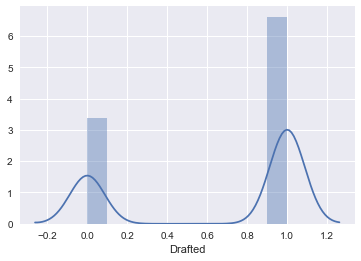

In [81]:
sns.distplot(new_df['Drafted'])

### First round of models - Drafted/Undrafted (No Polynomials)

#### Set features and target

In [83]:
X = new_plus_dummies.drop(columns = ['Round', 'Player', 'Drafted'])
y = new_plus_dummies['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

#### Random Forest GridSearchCV

In [91]:
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[4000, 4500], 'max_depth':[8,9,10,11,12], 'min_samples_split':[4,5,6]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.603376,0.169403,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.601927,0.170660,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.603096,0.170121,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
3,0.602273,0.169573,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
4,0.604584,0.169137,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
5,0.604543,0.169765,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
6,0.595396,0.171490,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
7,0.595887,0.171984,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
8,0.594762,0.171560,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
9,0.595734,0.171753,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."


In [92]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.6112460558407988
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 4000}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=4000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


#### KNN GridSearchCV

In [87]:
param_grid = {'weights':['uniform', 'distance'],'n_neighbors':[4,5,6,7,8]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
knn_grid.fit(X, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.588137,0.083879,"{'n_neighbors': 4, 'weights': 'uniform'}"
1,0.660656,0.064320,"{'n_neighbors': 4, 'weights': 'distance'}"
2,0.674356,0.069364,"{'n_neighbors': 5, 'weights': 'uniform'}"
3,0.673490,0.068529,"{'n_neighbors': 5, 'weights': 'distance'}"
4,0.629120,0.077533,"{'n_neighbors': 6, 'weights': 'uniform'}"
5,0.675086,0.072637,"{'n_neighbors': 6, 'weights': 'distance'}"
6,0.688069,0.074116,"{'n_neighbors': 7, 'weights': 'uniform'}"
7,0.687805,0.072720,"{'n_neighbors': 7, 'weights': 'distance'}"
8,0.649047,0.078949,"{'n_neighbors': 8, 'weights': 'uniform'}"
9,0.690214,0.068859,"{'n_neighbors': 8, 'weights': 'distance'}"


In [88]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.6902142494711143
{'n_neighbors': 8, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')


#### XGBoost

In [90]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 7, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.672468
F1: 0.749395


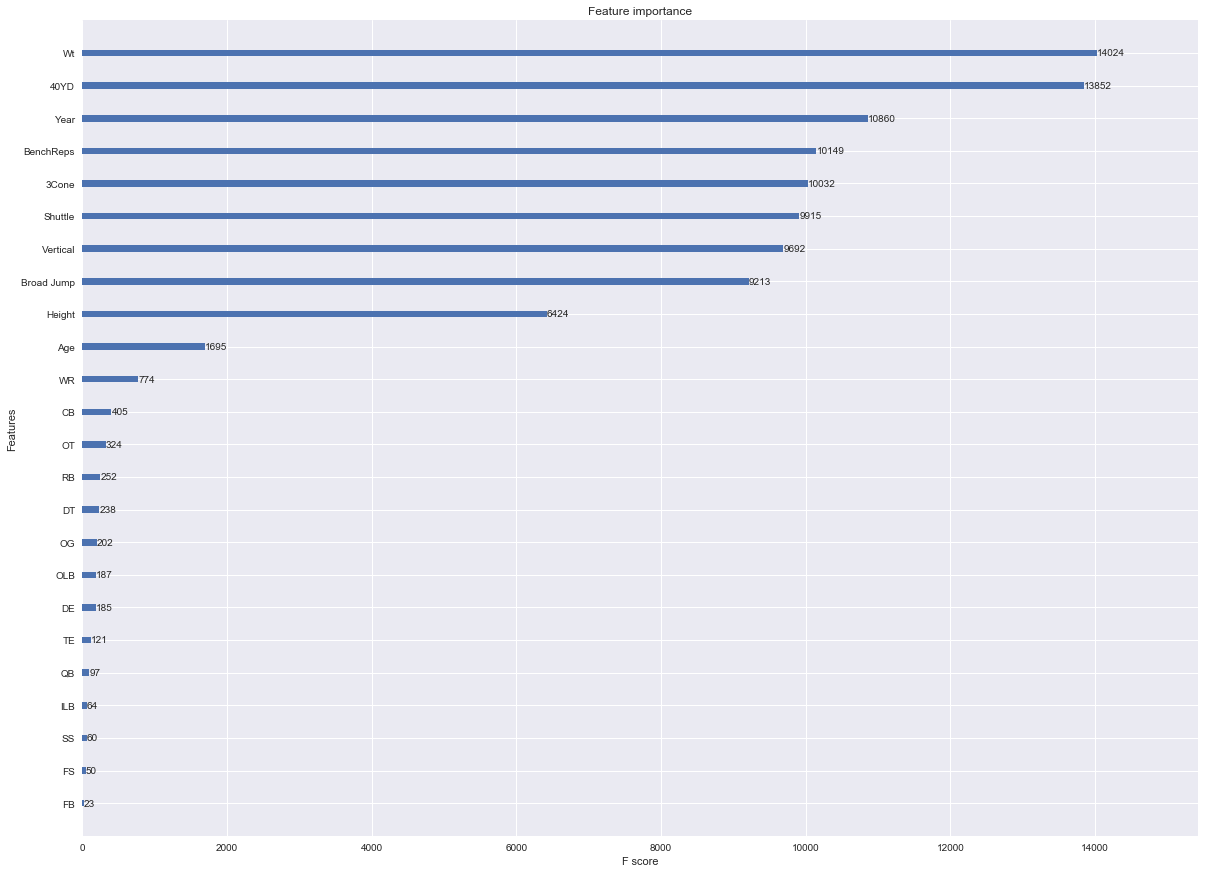

In [140]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [0,15]
plt.show()

### Second round of models - Drafted/Undrafted (Polynomials)

In [93]:
poly_2 = PolynomialFeatures(degree=2, interaction_only = False)
poly_2_df = pd.DataFrame(poly_2.fit_transform(X), columns=poly_2.get_feature_names(X.columns))
X_train_poly, X_test_poly, y_train, y_test = train_test_split(poly_2_df, y, test_size = .2)

In [94]:
poly_2_df.head()

,1,Year,Age,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,CB,DE,DT,FB,FS,ILB,OG,OLB,OT,QB,RB,SS,TE,WR,Year^2,Year Age,Year Height,Year Wt,Year 40YD,Year Vertical,Year BenchReps,Year Broad Jump,Year 3Cone,Year Shuttle,Year CB,Year DE,Year DT,Year FB,Year FS,Year ILB,Year OG,Year OLB,Year OT,Year QB,Year RB,Year SS,Year TE,Year WR,Age^2,Age Height,Age Wt,Age 40YD,Age Vertical,Age BenchReps,Age Broad Jump,Age 3Cone,Age Shuttle,Age CB,Age DE,Age DT,Age FB,Age FS,Age ILB,Age OG,Age OLB,Age OT,Age QB,Age RB,Age SS,Age TE,Age WR,Height^2,Height Wt,Height 40YD,Height Vertical,Height BenchReps,Height Broad Jump,Height 3Cone,Height Shuttle,Height CB,Height DE,Height DT,Height FB,Height FS,Height ILB,Height OG,Height OLB,Height OT,Height QB,Height RB,Height SS,Height TE,Height WR,Wt^2,Wt 40YD,Wt Vertical,Wt BenchReps,Wt Broad Jump,Wt 3Cone,Wt Shuttle,Wt CB,Wt DE,Wt DT,Wt FB,Wt FS,Wt ILB,Wt OG,Wt OLB,Wt OT,Wt QB,Wt RB,Wt SS,Wt TE,Wt WR,40YD^2,40YD Vertical,40YD BenchReps,40YD Broad Jump,40YD 3Cone,40YD Shuttle,40YD CB,40YD DE,40YD DT,40YD FB,40YD FS,40YD ILB,40YD OG,40YD OLB,40YD OT,40YD QB,40YD RB,40YD SS,40YD TE,40YD WR,Vertical^2,Vertical BenchReps,Vertical Broad Jump,Vertical 3Cone,Vertical Shuttle,Vertical CB,Vertical DE,Vertical DT,Vertical FB,Vertical FS,Vertical ILB,Vertical OG,Vertical OLB,Vertical OT,Vertical QB,Vertical RB,Vertical SS,Vertical TE,Vertical WR,BenchReps^2,BenchReps Broad Jump,BenchReps 3Cone,BenchReps Shuttle,BenchReps CB,BenchReps DE,BenchReps DT,BenchReps FB,BenchReps FS,BenchReps ILB,BenchReps OG,BenchReps OLB,BenchReps OT,BenchReps QB,BenchReps RB,BenchReps SS,BenchReps TE,BenchReps WR,Broad Jump^2,Broad Jump 3Cone,Broad Jump Shuttle,Broad Jump CB,Broad Jump DE,Broad Jump DT,Broad Jump FB,Broad Jump FS,Broad Jump ILB,Broad Jump OG,Broad Jump OLB,Broad Jump OT,Broad Jump QB,Broad Jump RB,Broad Jump SS,Broad Jump TE,Broad Jump WR,3Cone^2,3Cone Shuttle,3Cone CB,3Cone DE,3Cone DT,3Cone FB,3Cone FS,3Cone ILB,3Cone OG,3Cone OLB,3Cone OT,3Cone QB,3Cone RB,3Cone SS,3Cone TE,3Cone WR,Shuttle^2,Shuttle CB,Shuttle DE,Shuttle DT,Shuttle FB,Shuttle FS,Shuttle ILB,Shuttle OG,Shuttle OLB,Shuttle OT,Shuttle QB,Shuttle RB,Shuttle SS,Shuttle TE,Shuttle WR,CB^2,CB DE,CB DT,CB FB,CB FS,CB ILB,CB OG,CB OLB,CB OT,CB QB,CB RB,CB SS,CB TE,CB WR,DE^2,DE DT,DE FB,DE FS,DE ILB,DE OG,DE OLB,DE OT,DE QB,DE RB,DE SS,DE TE,DE WR,DT^2,DT FB,DT FS,DT ILB,DT OG,DT OLB,DT OT,DT QB,DT RB,DT SS,DT TE,DT WR,FB^2,FB FS,FB ILB,FB OG,FB OLB,FB OT,FB QB,FB RB,FB SS,FB TE,FB WR,FS^2,FS ILB,FS OG,FS OLB,FS OT,FS QB,FS RB,FS SS,FS TE,FS WR,ILB^2,ILB OG,ILB OLB,ILB OT,ILB QB,ILB RB,ILB SS,ILB TE,ILB WR,OG^2,OG OLB,OG OT,OG QB,OG RB,OG SS,OG TE,OG WR,OLB^2,OLB OT,OLB QB,OLB RB,OLB SS,OLB TE,OLB WR,OT^2,OT QB,OT RB,OT SS,OT TE,OT WR,QB^2,QB RB,QB SS,QB TE,QB WR,RB^2,RB SS,RB TE,RB WR,SS^2,SS TE,SS WR,TE^2,TE WR,WR^2
0,1.0,2018.0,23.0,75.0,306.0,5.430000,25.0000,20.00000,103.000000,7.90000,4.81000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4072324.0,46414.0,151350.0,617508.0,10957.740000,50450.000000,40360.000000,207854.000000,15942.200000,9706.580000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529.0,1725.0,7038.0,124.890000,575.000000,460.000000,2369.000000,181.700000,110.630000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5625.0,22950.0,407.250000,1875.000000,1500.000000,7725.000000,592.500000,360.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93636.0,1661.580000,7650.000000,6120.000000,31518.000000,2417.400000,1471.860000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.484900,135.750000,108.600000,559.290000,42.897000,26.118300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,625.000000,500.000000,2575.000000,197.500000,120.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.000000,2060.000000,158.000000,96.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10609.000000,813.700000,495.430000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [95]:
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[4000, 4500], 'max_depth':[8,9,10,11,12], 'min_samples_split':[4,5,6]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
rf_grid.fit(poly_2_df, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

KeyboardInterrupt: 

In [ ]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

In [ ]:
param_grid = {'weights':['uniform', 'distance'],'n_neighbors':[4,5,6,7,8]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1', return_train_score=False, n_jobs = -1)
knn_grid.fit(poly_2_df, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

In [ ]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 7, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train_poly,y_train)
preds = xg_clf.predict(X_test_poly)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

### Third round of Models - Round Drafted (No Polynomials)

In [141]:
X = new_plus_dummies.drop(columns = ['Round', 'Player', 'Drafted'])
y = new_plus_dummies['Round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [143]:
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[4000, 4500], 'max_depth':[8,9,10,11,12], 'min_samples_split':[4,5,6]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
rf_grid.fit(X, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.279000,0.071262,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
1,0.280266,0.072542,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
2,0.279316,0.072332,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
3,0.279633,0.072298,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
4,0.279475,0.071929,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
5,0.280108,0.072094,"{'criterion': 'gini', 'max_depth': 8, 'min_sam..."
6,0.272511,0.075685,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
7,0.272195,0.076013,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
8,0.273303,0.075464,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."
9,0.272828,0.075377,"{'criterion': 'gini', 'max_depth': 9, 'min_sam..."


In [144]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

0.28026586485203353
{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 4500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=4500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [145]:
param_grid = {'weights':['uniform', 'distance'],'n_neighbors':[4,5,6,7,8]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
knn_grid.fit(X, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.184839,0.022568,"{'n_neighbors': 4, 'weights': 'uniform'}"
1,0.200823,0.024643,"{'n_neighbors': 4, 'weights': 'distance'}"
2,0.193069,0.020601,"{'n_neighbors': 5, 'weights': 'uniform'}"
3,0.208577,0.023837,"{'n_neighbors': 5, 'weights': 'distance'}"
4,0.199399,0.019941,"{'n_neighbors': 6, 'weights': 'uniform'}"
5,0.216965,0.020507,"{'n_neighbors': 6, 'weights': 'distance'}"
6,0.210160,0.020162,"{'n_neighbors': 7, 'weights': 'uniform'}"
7,0.222978,0.024630,"{'n_neighbors': 7, 'weights': 'distance'}"
8,0.219813,0.021012,"{'n_neighbors': 8, 'weights': 'uniform'}"
9,0.229308,0.027536,"{'n_neighbors': 8, 'weights': 'distance'}"


In [146]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.22930843487893654
{'n_neighbors': 8, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')


In [142]:
xg_clf = xgb.XGBClassifier(objective ='multi:softmax', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 7, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
test_f1 = f1_score(y_test, preds, average = 'micro')
test_acc = accuracy_score(y_test, preds)
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.295095
F1: 0.295095


### Fourth round of models - Round Drafted (Polynomials)

In [ ]:
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[4000, 4500], 'max_depth':[8,9,10,11,12], 'min_samples_split':[4,5,6]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
rf_grid.fit(poly_2_df, y)
pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

In [ ]:
param_grid = {'weights':['uniform', 'distance'],'n_neighbors':[4,5,6,7,8]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='f1_micro', return_train_score=False, n_jobs = -1)
knn_grid.fit(poly_2_df, y)
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

In [ ]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

In [ ]:
xg_clf = xgb.XGBClassifier(objective ='multi:softmax', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.3,
                           max_depth = 7, 
                           alpha = 0.5, 
                           scale_pos_weight= .5,
                           n_estimators = 10000)
xg_clf.fit(X_train_poly,y_train)
preds = xg_clf.predict(X_test_poly)
test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds, average = 'micro')
print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))